In [1]:
# from https://towardsdatascience.com/temporal-fusion-transformer-a-primer-on-deep-forecasting-in-python-4eb37f3f3594
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

/var/folders/z0/x8p7hmr50s5ff0l4lsmb_z300000gn/T/ipykernel_52893/2161285457.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Load Data

In [4]:
df = pd.read_csv("total_rides_18_19.csv", sep=",", index_col=0)

# convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# sort by date
df.sort_values(by=['date'], inplace=True)

# add month and year as seperate columns
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month

# add weekday information
df['week_day'] = pd.to_datetime(df['date']).dt.strftime('%A')

# ordinal encode weekdays
enc = OrdinalEncoder()
df['week_day_enc'] = enc.fit_transform(np.asarray(df['week_day']).reshape(-1,1))

# change invalid counts
df.loc[df['nb_rides']<100000, 'nb_rides'] = 650000

### small training set for test run

In [5]:
# split in train and test
start_date = '2019-01-01'
split_date = '2020-02-01'
end_date = '2020-03-01'
keep_col = ['date', 'nb_rides', 'year', 'month', 'week_day_enc']
df_train = df[(df['date']>=start_date) & (df['date']<split_date)][keep_col].copy()
df_test = df[(df['date']>=split_date) & (df['date']<=end_date)][keep_col].copy()

print(f"The train set contains {df_train.shape[0]} obervations from {start_date} to {split_date}")
print(f"The test set contains {df_test.shape[0]} obervations from {split_date} to {end_date}")

The train set contains 398 obervations from 2019-01-01 to 2020-02-01
The test set contains 30 obervations from 2020-02-01 to 2020-03-01


In [6]:
# create smaller df for testing 
df_small = df[(df['date']>=start_date) & (df['date']<end_date)][keep_col].copy()
print(f"The small set contains {df_small.shape[0]} obervations from {start_date} to {end_date}")

The small set contains 427 obervations from 2019-01-01 to 2020-03-01


In [11]:
# check for missing values
df_small.isnull().values.any()

False

In [45]:
# drop all duplicate indices
df_small = df_small[df_small['date'].duplicated(keep='first')==False]

## TFT Model

In [48]:
# create time series object from dataframe
df_small['datetime'] = pd.to_datetime(df_small['date'])
df_ts = df_small[['datetime', 'nb_rides']].set_index('datetime')
ts = TimeSeries.from_series(df_ts['nb_rides'], fill_missing_dates=True, freq=None)

#df_train['datetime'] = pd.to_datetime(df_train['date'])
#df_train = df_train.set_index('datetime')

#df_test['datetime'] = pd.to_datetime(df_test['date'])
#df_test = df_test.set_index('datetime')

#ts_train = TimeSeries.from_series(df_train['nb_rides'])
#ts_test = TimeSeries.from_series(df_test['nb_rides'])

In [57]:
# parameters

EPOCHS = 400   # number of training cycles, default 100
INLEN = 60     # size of input layer 
HIDDEN = 31    # hidden layers
LSTMLAYERS = 1 # layers for the Long Short Term Memory encoder/decoder
ATTHEADS = 2   # attention layers, 2 for simple datasets, 4 for complex datasets
DROPOUT = 0.1  # dropout rate to avoid overfitting
BATCH = 32     # number of training observations processed before updating parameters, default 32

TRAIN = "20200222"  # train/test split
N_FC = 7            # default forecast horizon, 7 days
RAND = 12           # set random state
MSEAS = 20          # upper limit of seasonality, 7 days, put more to test
ALPHA = 0.05        # significance level for seasonality test
N_JOBS = -1         # parallel processors to use;  -1 = all processors
N_SAMPLES = 50      # number of times a prediction is sampled from a probabilistic model


# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]
FIGSIZE = (9, 6)

qL1, qL2, qL3 = 0.01, 0.05, 0.10        # percentiles of predictions: lower bounds
qU1, qU2, qU3 = 1-qL1, 1-qL2, 1-qL3     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'
label_q3 = f'{int(qU3 * 100)} / {int(qL3 * 100)} percentile band'


In [50]:
# check for seasonality, via ACF
# to confirm seasonality of 7 days
mseas=MSEAS
for m in range(2, MSEAS):
    is_seasonal, mseas = check_seasonality(ts, m=m, alpha=ALPHA, max_lag=MSEAS)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {} days'.format(mseas))

seasonal? True
There is seasonality of order 7 days


In [51]:
# train/test
if isinstance(TRAIN, str):
    split = pd.Timestamp(TRAIN)
else:
    split = TRAIN
ts_train, ts_test = ts.split_after(split)

# scale the time series on the training settransformer = Scaler()
transformer = Scaler()
ts_ttrain = transformer.fit_transform(ts_train)
ts_ttest = transformer.transform(ts_test)
ts_t = transformer.transform(ts)

In [54]:
# create covariates: year, month, and integer index series
cov = datetime_attribute_timeseries(ts, attribute="year", one_hot=False)
cov = cov.stack(datetime_attribute_timeseries(ts, attribute="month", one_hot=False))
cov = cov.stack(datetime_attribute_timeseries(ts, attribute="day", one_hot=False))

cov = cov.stack(TimeSeries.from_times_and_values(
                                    times=ts.time_index, 
                                    values=np.arange(len(ts)), 
                                    columns=["linear_increase"]))
cov = cov.astype(np.float32)

# train/test
train_cov, test_cov = cov.split_after(split)


# rescale the covariates: fit on the training set
scaler = Scaler()
scaler.fit(train_cov)
tcov = scaler.transform(cov)

In [64]:
model = TFTModel(input_chunk_length=INLEN,
                output_chunk_length=N_FC,
                hidden_size=HIDDEN,
                lstm_layers=LSTMLAYERS,
                num_attention_heads=ATTHEADS,
                dropout=DROPOUT,
                batch_size=BATCH,
                n_epochs=EPOCHS,
                likelihood=QuantileRegression(quantiles=QUANTILES), 
                # loss_fn=MSELoss(),
                random_state=RAND, 
                force_reset=True)

In [65]:
model.fit(ts_ttrain, 
          future_covariates=tcov,
          verbose=True) 

Training: 0it [00:00, ?it/s]

In [66]:
# testing: generate predictions
ts_tpred = model.predict(n=len(ts_test), 
                         num_samples=N_SAMPLES,   
                         n_jobs=N_JOBS)
                            
print("Do the predictions constitute a probabilistic time series?", ts_tpred.is_probabilistic)                       

Predicting: 11it [00:00, ?it/s]

Do the predictions constitute a probabilistic time series? True


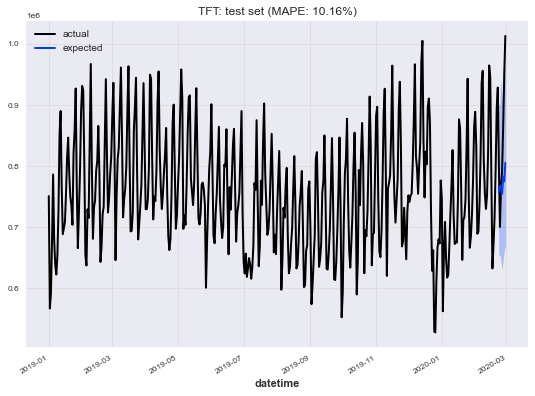

In [59]:
#from PIL import Image
#import pytesseract
# testing: helper function: plot predictions
def plot_predict(ts_actual, ts_test, ts_pred):
    
    ## plot time series, limited to forecast horizon
    plt.figure(figsize=FIGSIZE)
    
    ts_actual.plot(label="actual")                                       # plot actual
    
    #ts_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
    #ts_pred.plot(low_quantile=qL2, high_quantile=qU2, label=label_q2)   # plot U2 quantile band
    #ts_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
    ts_pred.plot(central_quantile="mean", label="expected")              # plot "mean" or median=0.5
    
    plt.title("TFT: test set (MAPE: {:.2f}%)".format(mape(ts_test, ts_pred)))
    plt.legend();  
    
    
    
 # testing: call helper function: plot predictions
ts_pred = transformer.inverse_transform(ts_tpred)
plot_predict(ts, ts_test, ts_pred)

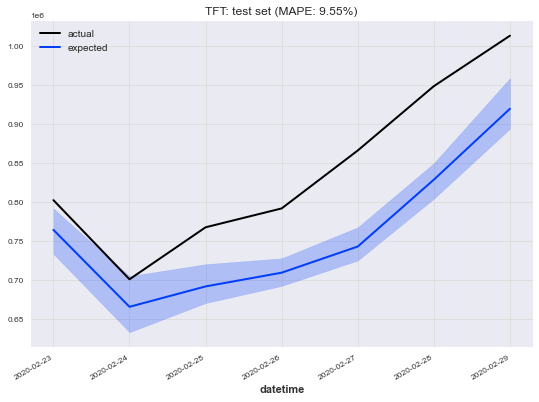

In [67]:
# testing: call helper function: plot predictions, focus on test set
ts_pred = transformer.inverse_transform(ts_tpred)
ts_actual = ts[ ts_tpred.start_time(): ts_tpred.end_time() ]  # actual values in forecast horizon
plot_predict(ts_actual, ts_test, ts_pred)

In [68]:

# testing: collect the prediction percentiles in a dataframe dfY
dfY = pd.DataFrame()

# helper method: calculate percentiles of predictions
def predQ(ts_tpred, q):
    ts_t = ts_tpred.quantile_timeseries(q)         # percentile of predictions
    ts = transformer.inverse_transform(ts_t)       # inverse-transform the percentile
    s = TimeSeries.pd_series(ts)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s

# fill Actual column into the new dataframe
dfY["Actual"] = TimeSeries.pd_series(ts_actual)

# call helper function: percentiles of predictions
quantiles = [0.5, qU1, qU2, qU3, qL3, qL2, qL1]
_ = [predQ(ts_tpred, q) for q in quantiles]
dfY.iloc[np.r_[0:2, -2:0]]

,Actual,Q50,Q99,Q95,Q90,Q10,Q05,Q01
datetime,,,,,,,,
2020-02-23,"802,030.00","764,869.56","810,699.96","791,204.29","788,921.30","738,785.92","733,014.45","720,499.62"
2020-02-24,"700,469.00","666,670.05","707,319.30","704,584.77","687,921.97","640,902.28","632,589.52","624,274.72"
2020-02-28,"948,234.00","827,186.65","867,057.25","849,467.19","845,596.06","805,995.23","803,814.84","803,500.35"
2020-02-29,"1,012,930.00","914,421.67","964,078.17","958,571.19","948,329.81","894,782.93","893,581.77","893,029.47"


In [69]:
def eval_tft(df_pred, plot=True):
    true_values = df_pred['Actual']
    predictions = df_pred['Q50']
    true_values_dates = df_pred.index
    pred_dates = df_pred.index
    
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    
    # evaluate forecasts with mae for mase comparison
    mae  = np.mean(np.abs(true_values - predictions))

    if plot:
        print('Test RMSE: %.3f' % rmse)
        # plot forecasts against actual outcomes
        plt.plot(true_values_dates, true_values, label='True Value')
        plt.plot(pred_dates, predictions, color='red', label='Predicted Value')
        plt.xlabel('date')
        plt.ylabel('number of rides')
        plt.legend()
        plt.title(f"Prophet predictions from {df_test.iloc[0]['date']} to {df_test.iloc[7]['date']} ")
        plt.show();
        
    return rmse, mae

Test RMSE: 88584.379


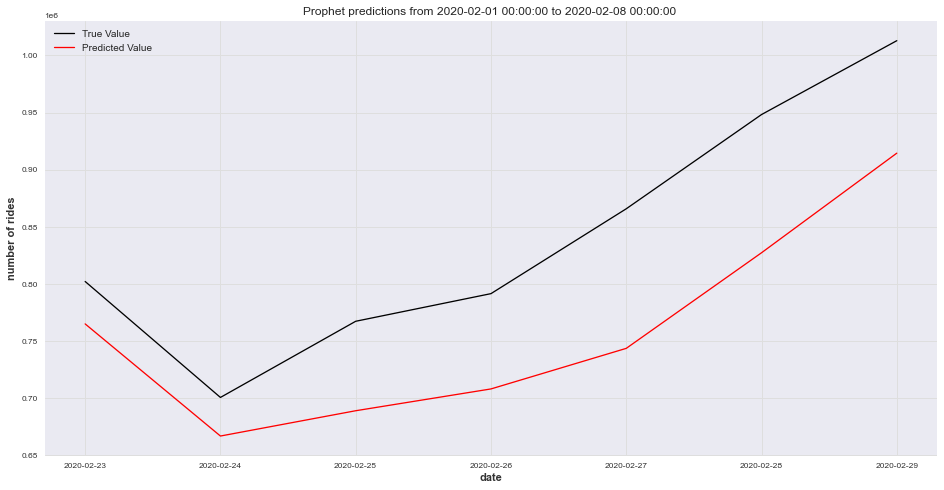

In [70]:
rmse, mae = eval_tft(dfY)

## Model Variations

In [115]:
# parameters
EPOCHS = 400 # number of trainin cycles, default 100 # davor 400 76000
INLEN = 90 # size of input layer 
HIDDEN = 31 # hidden layers
LSTMLAYERS = 1 # layers for the Long Short Term Memory encoder/decoder
ATTHEADS = 4 # attention layers, 2 for simple datasets, 4 for complex datasets
DROPOUT = 0.1 # dropout rate to avoid overfitting
BATCH = 32 # number of training observations processed before updating parameters, default 32

In [116]:
model = TFTModel(input_chunk_length=INLEN,
                output_chunk_length=N_FC,
                hidden_size=HIDDEN,
                lstm_layers=LSTMLAYERS,
                num_attention_heads=ATTHEADS,
                dropout=DROPOUT,
                batch_size=BATCH,
                n_epochs=EPOCHS,
                likelihood=QuantileRegression(quantiles=QUANTILES), 
                # loss_fn=MSELoss(),
                random_state=RAND, 
                force_reset=True)

In [117]:
model.fit(ts_ttrain, 
          future_covariates=tcov,
          verbose=True) 

Training: 0it [00:00, ?it/s]

In [118]:
# testing: generate predictions
ts_tpred = model.predict(n=len(ts_test), 
                         num_samples=N_SAMPLES,   
                         n_jobs=N_JOBS)
                            
print("Do the predictions constitute a probabilistic time series?", ts_tpred.is_probabilistic)                       

Predicting: 11it [00:00, ?it/s]

Do the predictions constitute a probabilistic time series? True


In [119]:
# fill Actual column into the new dataframe
dfY["Actual"] = TimeSeries.pd_series(ts_actual)

# call helper function: percentiles of predictions
quantiles = [0.5, qU1, qU2, qU3, qL3, qL2, qL1]
_ = [predQ(ts_tpred, q) for q in quantiles]

Test RMSE: 123219.644


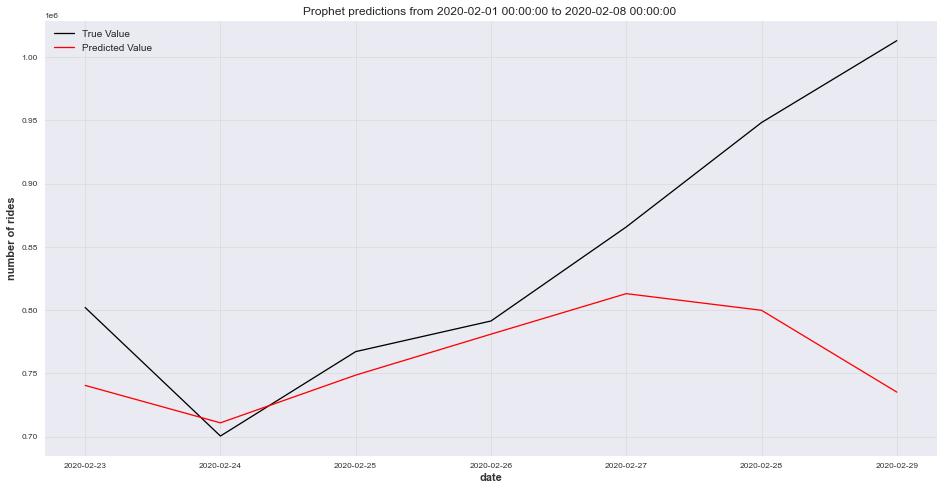

In [120]:
rmse, mae = eval_tft(dfY)

In [121]:
# save model
model.save_model('./TFT models/model_1.pth.tar')

In [82]:
# parameters
EPOCHS = 400 # number of trainin cycles, default 100
INLEN = 90 # size of input layer 
HIDDEN = 31 # hidden layers
LSTMLAYERS = 3 # layers for the Long Short Term Memory encoder/decoder
ATTHEADS = 4 # attention layers, 2 for simple datasets, 4 for complex datasets
DROPOUT = 0.1 # dropout rate to avoid overfitting
BATCH = 32 # number of training observations processed before updating parameters, default 32

model = TFTModel(input_chunk_length=INLEN,
                output_chunk_length=N_FC,
                hidden_size=HIDDEN,
                lstm_layers=LSTMLAYERS,
                num_attention_heads=ATTHEADS,
                dropout=DROPOUT,
                batch_size=BATCH,
                n_epochs=EPOCHS,
                likelihood=QuantileRegression(quantiles=QUANTILES), 
                # loss_fn=MSELoss(),
                random_state=RAND, 
                force_reset=True)

model.fit(ts_ttrain, 
          future_covariates=tcov,
          verbose=True) 

Training: 0it [00:00, ?it/s]

In [83]:
# testing: generate predictions
ts_tpred = model.predict(n=len(ts_test), 
                         num_samples=N_SAMPLES,   
                         n_jobs=N_JOBS)

# fill Actual column into the new dataframe
dfY["Actual"] = TimeSeries.pd_series(ts_actual)

# call helper function: percentiles of predictions
quantiles = [0.5, qU1, qU2, qU3, qL3, qL2, qL1]
_ = [predQ(ts_tpred, q) for q in quantiles]

Predicting: 11it [00:00, ?it/s]

Test RMSE: 96276.567


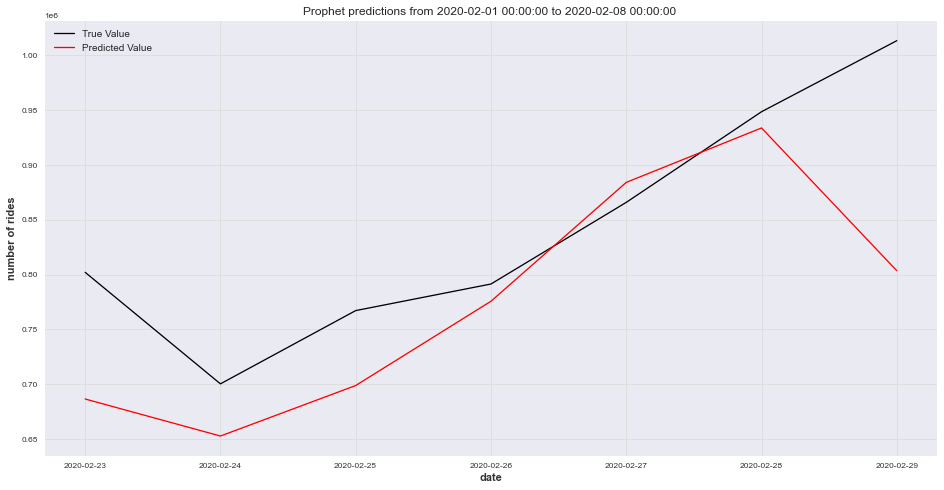

In [84]:
rmse, mae = eval_tft(dfY)

Training: 0it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Test RMSE: 64478.088


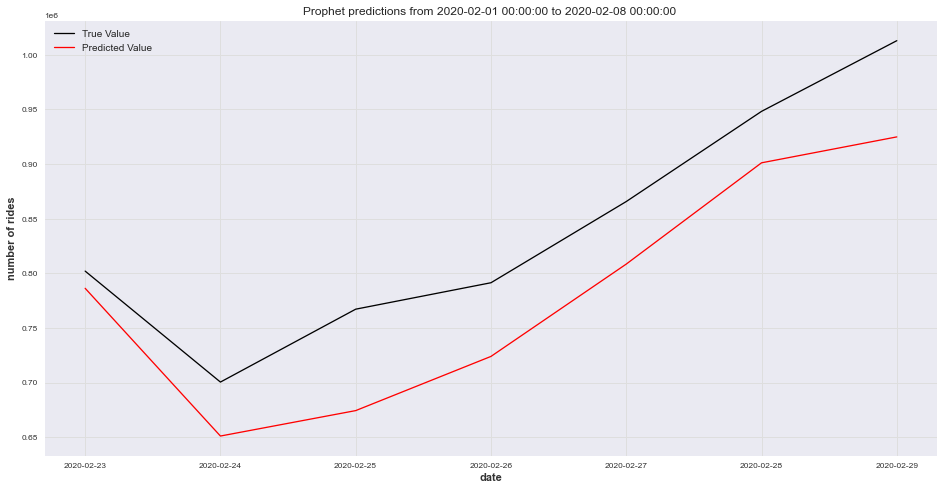

In [122]:
# parameters
EPOCHS = 400
INLEN = 128 # size of input layer, bigger than order of seasonality, power of 2 for efficient memory usage (512)
HIDDEN = 64 # hidden layers, 2:1 input:hidden
LSTMLAYERS = 1 # layers for the Long Short Term Memory encoder/decoder
ATTHEADS = 4 # attention layers, 2 for simple datasets, 4 for complex datasets
DROPOUT = 0.1 # dropout rate to avoid overfitting
BATCH = 32 # number of training observations processed before updating parameters, default 32

model = TFTModel(input_chunk_length=INLEN,
                output_chunk_length=N_FC,
                hidden_size=HIDDEN,
                lstm_layers=LSTMLAYERS,
                num_attention_heads=ATTHEADS,
                dropout=DROPOUT,
                batch_size=BATCH,
                n_epochs=EPOCHS,
                likelihood=QuantileRegression(quantiles=QUANTILES), 
                # loss_fn=MSELoss(),
                random_state=RAND, 
                force_reset=True)

model.fit(ts_ttrain, 
          future_covariates=tcov,
          verbose=True) 

# testing: generate predictions
ts_tpred = model.predict(n=len(ts_test), 
                         num_samples=N_SAMPLES,   
                         n_jobs=N_JOBS)

# fill Actual column into the new dataframe
dfY["Actual"] = TimeSeries.pd_series(ts_actual)

# call helper function: percentiles of predictions
quantiles = [0.5, qU1, qU2, qU3, qL3, qL2, qL1]
_ = [predQ(ts_tpred, q) for q in quantiles]

rmse, mae = eval_tft(dfY)

In [124]:
dfY

,Actual,Q50,Q99,Q95,Q90,Q10,Q05,Q01
datetime,,,,,,,,
2020-02-23,"802,030.00","786,288.76","807,923.04","799,680.22","796,966.65","773,374.06","772,467.65","762,990.31"
2020-02-24,"700,469.00","651,078.15","676,535.63","673,426.23","659,387.88","643,135.09","639,152.60","632,166.67"
2020-02-25,"767,185.00","674,357.23","688,476.38","682,678.62","682,043.75","668,131.08","659,748.53","657,553.21"
2020-02-26,"791,385.00","723,952.02","739,867.50","733,877.13","731,736.44","718,870.32","706,873.24","704,220.52"
2020-02-27,"865,705.00","808,453.96","823,583.79","818,196.12","817,336.99","803,374.62","801,968.08","798,515.73"
2020-02-28,"948,234.00","901,146.67","915,307.51","910,202.51","909,071.67","894,274.43","889,092.64","881,869.16"
2020-02-29,"1,012,930.00","924,863.98","944,503.65","940,281.19","934,554.72","916,019.21","914,952.28","906,054.38"


In [130]:
true_values = dfY['Actual']
predictions = dfY['Q99']
rmse = np.sqrt(mean_squared_error(true_values, predictions))
rmse

49276.40616732699

In [86]:
dfY

,Actual,Q50,Q99,Q95,Q90,Q10,Q05,Q01
datetime,,,,,,,,
2020-02-23,"802,030.00","686,686.43","772,851.96","737,625.14","733,403.82","634,408.11","631,566.10","610,080.73"
2020-02-24,"700,469.00","652,964.22","768,031.35","760,443.54","718,620.79","613,581.27","605,123.08","595,730.34"
2020-02-25,"767,185.00","698,942.13","797,189.55","777,206.53","765,028.22","655,570.70","640,523.92","637,144.86"
2020-02-26,"791,385.00","775,677.34","877,735.87","848,216.16","830,077.61","734,487.07","713,842.89","710,500.05"
2020-02-27,"865,705.00","883,905.11","956,498.90","937,786.61","926,134.78","839,030.36","827,500.89","813,634.20"
2020-02-28,"948,234.00","933,466.86","987,707.50","962,729.20","957,415.34","864,245.66","823,789.10","803,841.51"
2020-02-29,"1,012,930.00","803,477.70","943,026.87","928,238.63","895,560.02","705,707.59","696,551.92","684,652.40"


In [93]:
true_values = dfY['Actual']
predictions = dfY['Q90']
rmse = np.sqrt(mean_squared_error(true_values, predictions))
rmse

58618.108272389574

start: 2019-07-20 00:00:00
months: 7


  0%|          | 0/19 [00:00<?, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

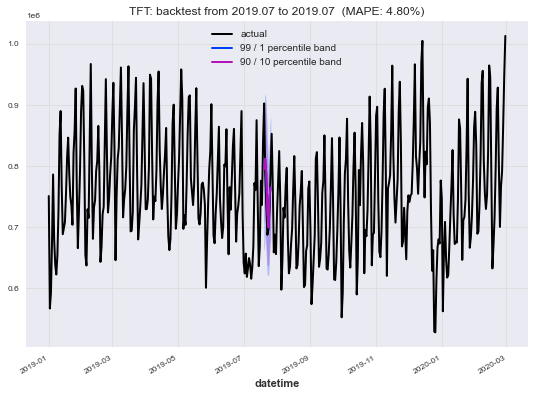

In [96]:
# backtest the model: predictions vs actual values

# start: at 10% of time series
STARTBACKT = ts.get_timestamp_at_point(point=1)  #pd.Timestamp("19500301")
print("start:",STARTBACKT)

# forecast horizon: until end of test period
tdiff = (   pd.to_datetime(ts.end_time()).to_period("M") - 
            pd.to_datetime(STARTBACKT).to_period("M")).n
print("months:",tdiff)

ts_tbacktest = model.historical_forecasts(  series=ts_t,
                                            past_covariates=None, 
                                            future_covariates=tcov,
                                            start=STARTBACKT,  
                                            num_samples=N_SAMPLES,
                                            forecast_horizon=tdiff,
                                            stride=12,
                                            last_points_only=False,
                                            retrain=False,
                                            verbose=True)
                                            
                                            
# backtesting: helper function: plot backtest predictions
def plot_backtest(ts_backtest, ts_actual, transformer):
    plt.figure(figsize=FIGSIZE)
    ts_actual.plot(label="actual")
    ts_backtest.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)
    ts_backtest.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)
    plt.legend()
    MAPE = "MAPE: {:.2f}%".format(mape(ts_actual, ts_backtest))
    plt.title(  "TFT: backtest from " + \
                format(ts_backtest.start_time(), "%Y.%m") + \
                " to " + format(ts_backtest.end_time(), "%Y.%m") + \
                "  (" + MAPE + ")");
       
       
# backtesting: call helper function: plot backtest
ts_backtest = transformer.inverse_transform(ts_tbacktest)

plot_backtest(  ts_backtest=concatenate(ts_backtest),
                ts_actual=ts,
                transformer=transformer)

## Grid Search

In [99]:
# randomized gridsearch
parameters = {  "input_chunk_length":[32, 64], 
                "output_chunk_length":[7],
                "hidden_size":[32, 64], 
                "lstm_layers":[2, 4], 
                "num_attention_heads":[2, 4], 
                "dropout":[0.1, 0.3], 
                "batch_size":[32, 64], 
                "n_epochs":[700]
                }

res = TFTModel.gridsearch(    
                            parameters=parameters,
                            series=ts_ttrain, 
                            future_covariates=tcov, 
                            val_series=ts_ttest,   
                            start=0.1,                 # starting point in training set 
                            last_points_only=False, 
                            metric=mape, 
                            reduction=np.mean, 
                            n_jobs=N_JOBS, 
                            n_random_samples=0.99,      # % of full search space to evaluate
                            verbose=True)
bestmodel, dict_bestparams = res

  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Model Details

In [131]:
model.save_model('./TFT models/model_400_128_64_1_4.pth.tar')
# parameters
EPOCHS = 400
INLEN = 128 # size of input layer, bigger than order of seasonality, power of 2 for efficient memory usage (512)
HIDDEN = 64 # hidden layers, 2:1 input:hidden
LSTMLAYERS = 1 # layers for the Long Short Term Memory encoder/decoder
ATTHEADS = 4 # attention layers, 2 for simple datasets, 4 for complex datasets
DROPOUT = 0.1 # dropout rate to avoid overfitting
BATCH = 32 # number of training observations processed before updating parameters, default 32

In [132]:
from darts.models import RNNModel

model_loaded = RNNModel.load_model("./TFT models/model_400_128_64_1_4.pth.tar")

Predicting: 0it [00:00, ?it/s]

Test RMSE: 64001.697


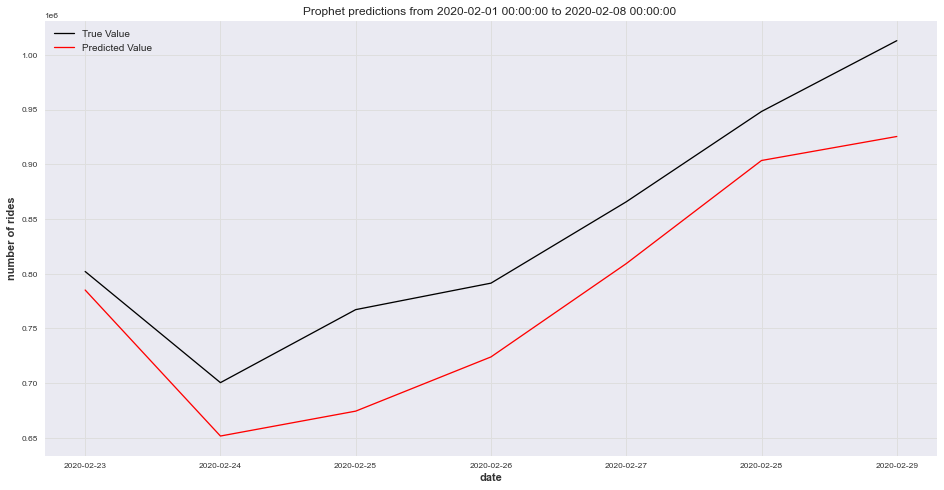

In [133]:
# testing: generate predictions
ts_tpred = model_loaded.predict(n=len(ts_test), 
                         num_samples=N_SAMPLES,   
                         n_jobs=N_JOBS)

# fill Actual column into the new dataframe
dfY["Actual"] = TimeSeries.pd_series(ts_actual)

# call helper function: percentiles of predictions
quantiles = [0.5, qU1, qU2, qU3, qL3, qL2, qL1]
_ = [predQ(ts_tpred, q) for q in quantiles]

rmse, mae = eval_tft(dfY)